In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
from torch import nn
from torchsummary import summary
from torchmetrics import Accuracy, F1Score, ConfusionMatrix
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

from ultralytics import YOLO
from PIL import Image
import warnings

warnings.filterwarnings('ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

c:\Users\Orit\Documents\kcn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='cpu')

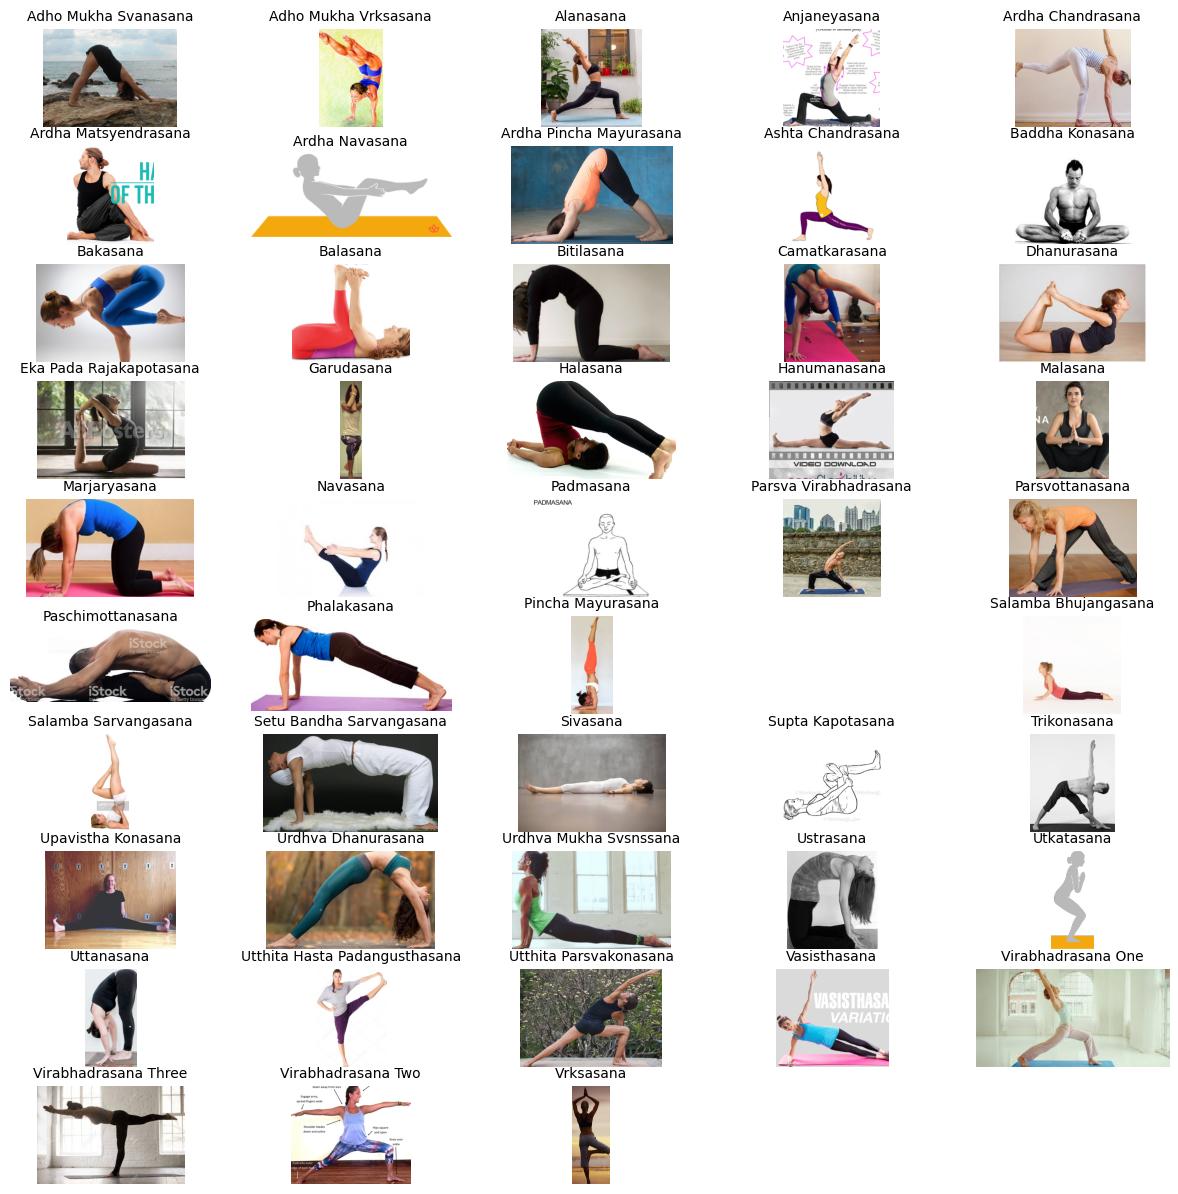

In [6]:
fig = plt.figure(figsize=(15,15))

image_folder = r".\yoga_posture_dataset"
for index, label in enumerate(os.listdir(image_folder)):
    if label == "Poses.json":
        continue
    
    image_list = os.listdir(os.path.join(image_folder,label))
    if len(image_list) == 0:
        os.remove(os.path.join(image_folder,label))
  
    
    img = random.choice(image_list)
    img = Image.open(os.path.join(image_folder,label,img))
    
    fig.add_subplot(10,5,index+1)
    plt.imshow(img)
    plt.title(label, fontsize=10)
    plt.axis("off")
plt.show()

In [7]:
model_yolo = YOLO("yolo11x-pose.pt")

In [11]:
data = []

# Loop for each label
for label in os.listdir(image_folder):
    # Loop for each image per label
    if label == "Poses.json":
        continue
    image_dir = os.path.join(image_folder,label)
    print(image_dir)
    for img in os.listdir(image_dir):
        #image = os.path.join(image_folder,image_dir,img)
        image = os.path.join(image_dir,img)
        print(image)
        # Extracting keypoint with YOLOv8
        results = model_yolo.predict(image, boxes=False, verbose=False)
        for r in results:
            keypoints = r.keypoints.xyn.cpu().numpy()[0]
            keypoints = keypoints.reshape((1, keypoints.shape[0]*keypoints.shape[1]))[0].tolist()
            keypoints.append(image) #insert image path
            keypoints.append(label) #insert image label

            data.append(keypoints)

.\yoga_posture_dataset\Adho Mukha Svanasana
.\yoga_posture_dataset\Adho Mukha Svanasana\File1.png
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
.\yoga_posture_dataset\Adho Mukha Svanasana\File10.png
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
.\yoga_posture_dataset\Adho Mukha Svanasana\File11.png
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
.\yoga_posture_dataset\Adho Mukha Svanasana\File12.png
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
.\yoga_posture_dataset\Adho Mukha Svanasana\File13.png
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
.\yoga_posture_dataset\Adho Mukha Svanasana\File14.png
WARNING 'boxes' is deprecated and will be removed in in the future. Use 'show_boxes' instead.
.\yoga_posture_dataset\Adho Mukha Svanasana\File15.png
WARNING 

KeyboardInterrupt: 

In [18]:
print(len(data[0]))     # should be 51 if full (x, y, conf) for 17 keypoints
print(data[0])          # see structure

36
[0.4252367913722992, 0.6472055315971375, 0.4170929491519928, 0.6487738490104675, 0.42648565769195557, 0.6433259844779968, 0.4041905403137207, 0.617397665977478, 0.4265581965446472, 0.6085078716278076, 0.39984145760536194, 0.539359986782074, 0.43061771988868713, 0.513510525226593, 0.3307859003543854, 0.7004563808441162, 0.36487865447998047, 0.6579177379608154, 0.2693595290184021, 0.8681889772415161, 0.2701077163219452, 0.7980833053588867, 0.5500451922416687, 0.23341840505599976, 0.573976993560791, 0.24794140458106995, 0.6555387377738953, 0.4548704922199249, 0.6709251403808594, 0.4243720769882202, 0.0, 0.0, 0.0, 0.0, '.\\yoga_posture_dataset\\Adho Mukha Svanasana\\File1.png', 'Adho Mukha Svanasana']


In [21]:
total_features = len(data[0])
df = pd.DataFrame(
    data=data, 
    columns=[f"x{i}" for i in range(total_features)]
    ).rename({
        "x34":"image_path", "x35":"label"
        }, axis=1)

df = df.dropna() #delete undetected pose 
df = df.iloc[:, 2:]

print(f"Total features {len(df.columns)-2}")
df.head()
df.to_csv("pose_features.csv", index=False)

Total features 32


In [22]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

classes_dict = {key:le.inverse_transform([key])[0] for key in range(len(df['label'].unique()))}
num_classes = len(classes_dict)

print(f"Total classes: {num_classes} ")
print(classes_dict)

Total classes: 4 
{0: 'Adho Mukha Svanasana', 1: 'Adho Mukha Vrksasana', 2: 'Alanasana', 3: 'Anjaneyasana'}


Split and Load Data

In [23]:
X = df.drop(["label","image_path"], axis=1).values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

In [24]:
train_tensor = TensorDataset(X_train, y_train)
test_tensor = TensorDataset(X_test, y_test) 

In [25]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_tensor, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_tensor, batch_size=BATCH_SIZE, shuffle=False)

The Model

In [26]:
class YogaClassifier(nn.Module):
  def __init__(self, num_classes, input_length):
    super().__init__()
    self.layer1 = nn.Linear(in_features=input_length, out_features=64)
    self.activation = nn.ReLU()
    self.dropout = nn.Dropout(0.2)
    self.layer2 = nn.Linear(in_features=64, out_features=64)
    self.outlayer = nn.Linear(in_features=64, out_features=num_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.activation(x)
    x = self.dropout(x)
    x = self.layer2(x)
    x = self.activation(x)
    x = self.outlayer(x)
    return x

input_length = X.shape[1]
model = YogaClassifier(num_classes=num_classes, input_length=input_length).to(device)
summary(model, input_size=(X.shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 204, 64]           2,112
              ReLU-2              [-1, 204, 64]               0
           Dropout-3              [-1, 204, 64]               0
            Linear-4              [-1, 204, 64]           4,160
              ReLU-5              [-1, 204, 64]               0
            Linear-6               [-1, 204, 4]             260
Total params: 6,532
Trainable params: 6,532
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.50
Params size (MB): 0.02
Estimated Total Size (MB): 0.55
----------------------------------------------------------------


Training Loop

In [27]:
accuracy_score = Accuracy(task="multiclass", num_classes=num_classes).to(device)
f1_score = F1Score(task="multiclass", num_classes=num_classes).to(device)

def train_step(model, dataloader, optimizer, loss_fn):
    model.train()
    train_loss, train_acc, train_f1 = 0, 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        #loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        #accuracy
        logits = torch.softmax(y_pred, dim=1)
        class_prediction = torch.argmax(logits, dim=1)
        acc = accuracy_score(class_prediction, y)
        f1 = f1_score(class_prediction, y)
        train_acc += acc.item()
        train_f1 += f1.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    train_f1 /= len(dataloader)

    return train_loss, train_acc, train_f1

def test_step(model, dataloader, loss_fn):
    model.eval()
    test_loss, test_acc, test_f1 = 0, 0, 0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            #loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            #accuracy
            logits = torch.softmax(y_pred, dim=1)
            class_prediction = torch.argmax(logits, dim=1)
            acc = accuracy_score(class_prediction, y)
            f1 = f1_score(class_prediction, y)
            test_acc += acc.item()
            test_f1 += f1.item()

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    test_f1 /= len(dataloader)
    return test_loss, test_acc, test_f1

In [28]:
def train_loop(model, trainloader, testloader, optimizer, loss_fn, epochs, verbose=True):
    history = {
        "train_loss": [],
        "train_accuracy": [],
        "train_f1": [],
        "test_loss": [],
        "test_accuracy": [],
        "test_f1": [],
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_f1 = train_step(
            model=model,
            dataloader=trainloader,
            optimizer=optimizer,
            loss_fn=loss_fn
        )

        test_loss, test_acc, test_f1 = test_step(
            model=model,
            dataloader=testloader,
            loss_fn=loss_fn
        )
       
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['test_loss'].append(test_loss)
        history['test_accuracy'].append(test_acc)
        history['test_f1'].append(test_f1)
    
        # Checkpoint
        best = max(history['test_accuracy'])
        best_epoch = history['test_accuracy'].index(best) 
   
        if test_acc < best:
            status = f"Accuracy not improved from epoch {best_epoch}"
        else: 
            status = f"Accuracy improved, saving weight....."
            torch.save(model.state_dict(), 'best.pth')

        if verbose:
            print(f"Epoch {epoch}")
            print(f"train loss: {train_loss} | test loss: {test_loss}")
            print(f"train accuracy: {train_acc} | test accuracy: {test_acc}")
            print(f"train f1: {train_f1} | test f1: {test_f1}")
            print(status)
            print("-------------------------------------------------")

    print(f"Best accuracy on epoch: {best_epoch}, accuracy: {best}")
    return history, best_epoch

Plot Result

In [29]:
def plot_result(train, test, ax, title, best_epoch):
    ax.plot(train, label='train')
    ax.plot(test, label='test')
    ax.axvline(x=best_epoch, color='blue', linestyle='--')
    ax.set_title(title)
    ax.legend()

Training Process

In [31]:
optimizer = torch.optim.Adam(lr=0.001, params=model.parameters())
loss_fn = nn.CrossEntropyLoss()
epochs = 15

result, best = train_loop(
      model=model,
      trainloader=train_dataloader,
      testloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      epochs=epochs,
      verbose=True
      )

  7%|▋         | 1/15 [00:01<00:26,  1.88s/it]

Epoch 0
train loss: 0.57953509191672 | test loss: 0.7103237509727478
train accuracy: 0.7959691981474558 | test accuracy: 0.7142857313156128
train f1: 0.7959691981474558 | test f1: 0.7142857313156128
Accuracy improved, saving weight.....
-------------------------------------------------


 13%|█▎        | 2/15 [00:02<00:17,  1.36s/it]

Epoch 1
train loss: 0.5235668271780014 | test loss: 0.7594709992408752
train accuracy: 0.8231431146462759 | test accuracy: 0.6666666865348816
train f1: 0.8231431146462759 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------


 20%|██        | 3/15 [00:03<00:14,  1.24s/it]

Epoch 2
train loss: 0.5232976873715719 | test loss: 0.6676236391067505
train accuracy: 0.8147644897301992 | test accuracy: 0.7142857313156128
train f1: 0.8147644897301992 | test f1: 0.7142857313156128
Accuracy improved, saving weight.....
-------------------------------------------------


 27%|██▋       | 4/15 [00:04<00:09,  1.12it/s]

Epoch 3
train loss: 0.5035549898942312 | test loss: 0.6534428596496582
train accuracy: 0.8188405831654867 | test accuracy: 0.7142857313156128
train f1: 0.8188405831654867 | test f1: 0.7142857313156128
Accuracy improved, saving weight.....
-------------------------------------------------
Epoch 4
train loss: 0.5073827654123306 | test loss: 0.7041023969650269
train accuracy: 0.7961956560611725 | test accuracy: 0.6666666865348816
train f1: 0.7961956560611725 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------


 40%|████      | 6/15 [00:04<00:04,  1.93it/s]

Epoch 5
train loss: 0.47004883488019306 | test loss: 0.6823839545249939
train accuracy: 0.8115941981474558 | test accuracy: 0.6666666865348816
train f1: 0.8115941981474558 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------
Epoch 6
train loss: 0.47262977560361225 | test loss: 0.6603448390960693
train accuracy: 0.8147644897301992 | test accuracy: 0.6666666865348816
train f1: 0.8147644897301992 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------


 53%|█████▎    | 8/15 [00:05<00:02,  2.63it/s]

Epoch 7
train loss: 0.4486822485923767 | test loss: 0.6577757000923157
train accuracy: 0.8584691981474558 | test accuracy: 0.6666666865348816
train f1: 0.8584691981474558 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------


 60%|██████    | 9/15 [00:05<00:02,  2.28it/s]

Epoch 8
train loss: 0.4614029179016749 | test loss: 0.6669520735740662
train accuracy: 0.8231431146462759 | test accuracy: 0.6666666865348816
train f1: 0.8231431146462759 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------


 67%|██████▋   | 10/15 [00:06<00:02,  2.00it/s]

Epoch 9
train loss: 0.46456501881281537 | test loss: 0.6525135636329651
train accuracy: 0.8199728230635325 | test accuracy: 0.6666666865348816
train f1: 0.8199728230635325 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------


 73%|███████▎  | 11/15 [00:06<00:01,  2.19it/s]

Epoch 10
train loss: 0.44091792901357013 | test loss: 0.6511433720588684
train accuracy: 0.8324275314807892 | test accuracy: 0.6666666865348816
train f1: 0.8324275314807892 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------


 87%|████████▋ | 13/15 [00:07<00:00,  3.15it/s]

Epoch 11
train loss: 0.44014182686805725 | test loss: 0.6834155321121216
train accuracy: 0.8469202915827433 | test accuracy: 0.6666666865348816
train f1: 0.8469202915827433 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------
Epoch 12
train loss: 0.41512472927570343 | test loss: 0.6473849415779114
train accuracy: 0.8231431146462759 | test accuracy: 0.6666666865348816
train f1: 0.8231431146462759 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------


100%|██████████| 15/15 [00:07<00:00,  1.99it/s]

Epoch 13
train loss: 0.42236963162819546 | test loss: 0.5963783264160156
train accuracy: 0.8469202915827433 | test accuracy: 0.6666666865348816
train f1: 0.8469202915827433 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------
Epoch 14
train loss: 0.42354614039262134 | test loss: 0.6129331588745117
train accuracy: 0.8367300728956858 | test accuracy: 0.6666666865348816
train f1: 0.8367300728956858 | test f1: 0.6666666865348816
Accuracy not improved from epoch 0
-------------------------------------------------
Best accuracy on epoch: 0, accuracy: 0.7142857313156128


Result Analysis

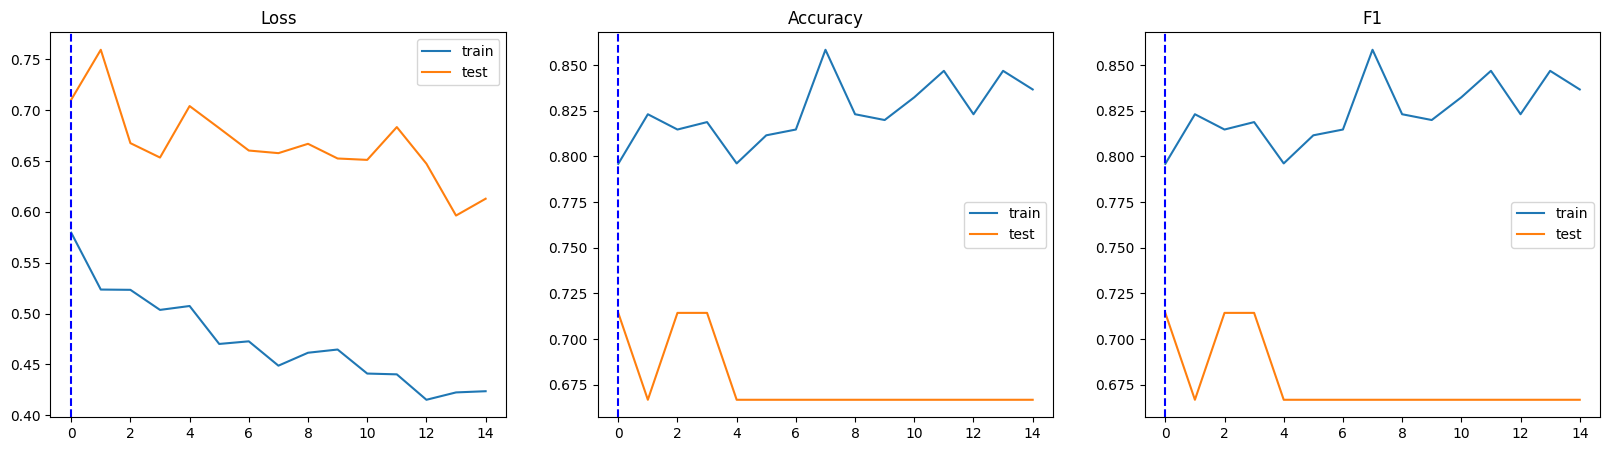

In [32]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,5))
plot_result(result['train_loss'], result['test_loss'], ax1, "Loss", best)
plot_result(result['train_accuracy'], result['test_accuracy'], ax2, "Accuracy", best)
plot_result(result['train_f1'], result['test_f1'], ax3, "F1", best)
plt.show()

In [33]:
def model_eval(model, dataloader):
    y_preds = []
    y_true = []
    model.eval()
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_logit = model(X)
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            y_preds.append(y_pred)
            y_true.append(y)

    y_pred = torch.cat(y_preds).cpu().numpy()
    y_test = torch.cat(y_true).cpu().numpy()

    report = classification_report(y_pred, y_test)
    cm = confusion_matrix(y_pred, y_test)

    return report, cm

In [34]:
model_pose = YogaClassifier(num_classes=num_classes, input_length=input_length).to(device)
model_pose.load_state_dict(torch.load(f="best.pth"))

<All keys matched successfully>

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.67      0.40      0.50         5
           2       0.00      0.00      0.00         0
           3       0.71      0.62      0.67         8

    accuracy                           0.67        21
   macro avg       0.54      0.47      0.50        21
weighted avg       0.73      0.67      0.69        21



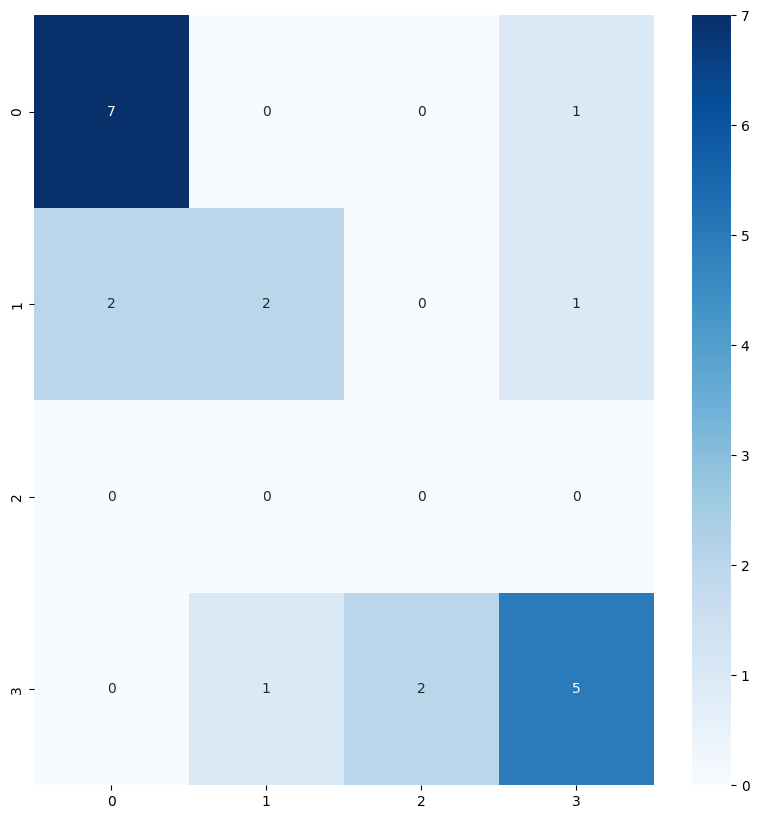

In [35]:
cls_report, cls_cm = model_eval(model, test_dataloader)

print(cls_report)

plt.figure(figsize=(10,10))
sns.heatmap(cls_cm, annot=True, fmt='g', cmap='Blues')
plt.show()

In [36]:
def make_prediction(image, true_label):
    results = model_yolo.predict(image, boxes=False, verbose=False)
    for r in results:
        im_array = r.plot(boxes=False)  # plot a BGR numpy array of predictions
        keypoints = r.keypoints.xyn.cpu().numpy()[0]
        keypoints = keypoints.reshape((1, keypoints.shape[0]*keypoints.shape[1]))[0].tolist()

    #Prediction
    model_pose.cpu()
    model_pose.eval()
    with torch.inference_mode():
        logit = model_pose(torch.tensor(keypoints[2:]))
        pred = torch.softmax(logit, dim=0).argmax(dim=0).item()
        prediction = classes_dict[pred]
    
    # if prediciton is correct, title color will be green.
    if prediction == true_label:
        color = 'green'
    else:
        color = 'red'
    
    plt.imshow(im_array[..., ::-1])
    plt.title(f"prediction:{prediction}\ntrue label:{true_label}", color=color)
    plt.show()

In [37]:
image_folder = "/kaggle/input/yoga-posture-dataset"
for label in os.listdir(image_folder):
    if label == 'Poses.json':
        continue
    
    true_label = label 
    
    image_list = os.listdir(os.path.join(image_folder,label))
    if len(image_list) == 0:
        continue
  
    img = random.choice(image_list)
    img = os.path.join(image_folder,label,img)
    make_prediction(img, true_label)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/kaggle/input/yoga-posture-dataset'